# Markowitz Portfolio Optimization

A Monte Carlo approach to finding optimal portfolios on the efficient frontier.

## 1. Data & Asset Universe

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Configuration
ASSETS = ['AAPL', 'MSFT', 'JNJ', 'PG', 'JPM']  # Tech + Healthcare + Consumer + Finance
BENCHMARK = 'SPY'
START_DATE = '2018-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')
RF = 0.03  # Annual risk-free rate (3%)
TRADING_DAYS = 252

print(f"Assets: {ASSETS}")
print(f"Period: {START_DATE} to {END_DATE}")
print(f"Risk-free rate: {RF:.1%}")

Assets: ['AAPL', 'MSFT', 'JNJ', 'PG', 'JPM']
Period: 2018-01-01 to 2026-01-31
Risk-free rate: 3.0%


In [4]:
# Download adjusted close prices
tickers = ASSETS + [BENCHMARK]
data = yf.download(tickers, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)['Close']
data = data.dropna()

prices = data[ASSETS]
benchmark_prices = data[[BENCHMARK]]

print(f"Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(f"Trading days: {len(prices)}")
print(f"\nLatest prices:")
print(prices.tail())

Date range: 2018-01-02 to 2026-01-30
Trading days: 2031

Latest prices:
Ticker            AAPL        MSFT         JNJ          PG         JPM
Date                                                                  
2026-01-26  255.410004  470.279999  221.490005  149.490005  301.040009
2026-01-27  258.269989  480.579987  224.440002  148.339996  300.309998
2026-01-28  256.440002  481.630005  227.720001  147.339996  300.769989
2026-01-29  258.279999  433.500000  227.289993  149.899994  306.420013
2026-01-30  259.480011  430.290009  227.250000  151.770004  305.890015


## 2. Returns & Risk Analysis

In [6]:
# Daily simple returns (used consistently throughout)
returns = prices.pct_change().dropna()
benchmark_returns = benchmark_prices.pct_change().dropna()

# Number of years in sample
n_years = len(returns) / TRADING_DAYS

# Annualized metrics per asset
# CAGR = (final / initial)^(1/years) - 1
cumulative_return = (1 + returns).prod()
cagr = cumulative_return ** (1 / n_years) - 1

# Annual volatility = daily std * sqrt(252)
annual_vol = returns.std() * np.sqrt(TRADING_DAYS)

# Sharpe ratio
sharpe = (cagr - RF) / annual_vol

# Summary table
asset_stats = pd.DataFrame({
    'CAGR': cagr,
    'Volatility': annual_vol,
    'Sharpe': sharpe
})

print("Individual Asset Statistics (Annualized):")
print("=" * 50)
display_stats = asset_stats.copy()
display_stats['CAGR'] = display_stats['CAGR'].apply(lambda x: f"{x:.2%}")
display_stats['Volatility'] = display_stats['Volatility'].apply(lambda x: f"{x:.2%}")
display_stats['Sharpe'] = display_stats['Sharpe'].apply(lambda x: f"{x:.2f}")
print(display_stats.to_string())

Individual Asset Statistics (Annualized):
          CAGR Volatility Sharpe
Ticker                          
AAPL    25.99%     30.71%   0.75
MSFT    23.41%     28.53%   0.72
JNJ      9.26%     19.56%   0.32
PG       9.54%     19.98%   0.33
JPM     17.00%     29.02%   0.48


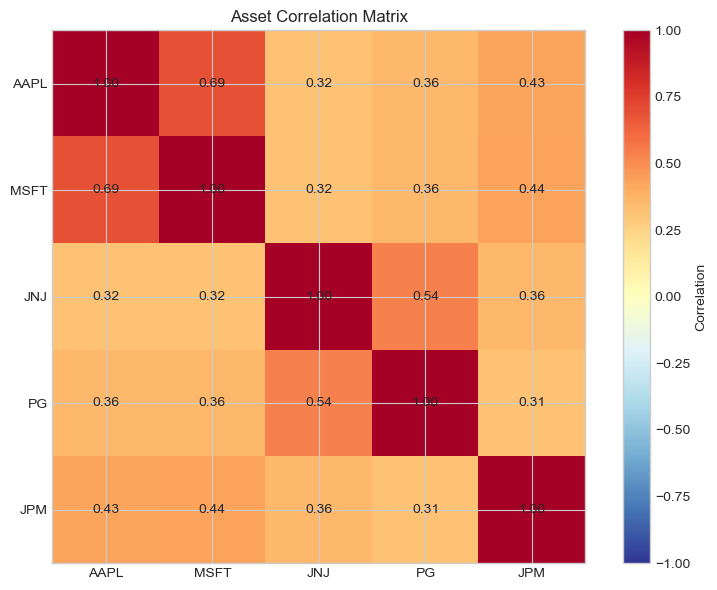

In [7]:
# Correlation matrix
corr_matrix = returns.corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(ASSETS)))
ax.set_yticks(range(len(ASSETS)))
ax.set_xticklabels(ASSETS)
ax.set_yticklabels(ASSETS)

for i in range(len(ASSETS)):
    for j in range(len(ASSETS)):
        ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', fontsize=10)

plt.colorbar(im, label='Correlation')
plt.title('Asset Correlation Matrix')
plt.tight_layout()
plt.show()

## 3. Portfolio Construction (Markowitz)

In [9]:
def portfolio_performance(weights, returns):
    """
    Calculate annualized return (CAGR) and volatility for a portfolio.
    
    Args:
        weights: array of portfolio weights
        returns: DataFrame of daily returns
    
    Returns:
        (annual_return, annual_volatility)
    """
    # Portfolio daily returns
    port_returns = returns.dot(weights)
    
    # CAGR (compounded annual growth rate)
    cumulative = (1 + port_returns).prod()
    n_years = len(port_returns) / TRADING_DAYS
    annual_return = cumulative ** (1 / n_years) - 1
    
    # Annual volatility
    annual_vol = port_returns.std() * np.sqrt(TRADING_DAYS)
    
    return annual_return, annual_vol

In [10]:
# Monte Carlo simulation: 10,000 random portfolios
np.random.seed(42)
N_PORTFOLIOS = 10000
n_assets = len(ASSETS)

# Storage
port_returns_arr = np.zeros(N_PORTFOLIOS)
port_vol_arr = np.zeros(N_PORTFOLIOS)
port_sharpe_arr = np.zeros(N_PORTFOLIOS)
port_weights_arr = np.zeros((N_PORTFOLIOS, n_assets))

print(f"Simulating {N_PORTFOLIOS:,} random portfolios...")

for i in range(N_PORTFOLIOS):
    # Random weights (long-only, sum to 1)
    w = np.random.random(n_assets)
    w = w / w.sum()
    
    # Calculate performance
    ret, vol = portfolio_performance(w, returns)
    sharpe = (ret - RF) / vol
    
    port_returns_arr[i] = ret
    port_vol_arr[i] = vol
    port_sharpe_arr[i] = sharpe
    port_weights_arr[i, :] = w

print("Done.")
print(f"\nReturn range: {port_returns_arr.min():.2%} to {port_returns_arr.max():.2%}")
print(f"Volatility range: {port_vol_arr.min():.2%} to {port_vol_arr.max():.2%}")
print(f"Sharpe range: {port_sharpe_arr.min():.2f} to {port_sharpe_arr.max():.2f}")

Simulating 10,000 random portfolios...
Done.

Return range: 10.47% to 25.19%
Volatility range: 16.65% to 26.50%
Sharpe range: 0.44 to 0.87


In [11]:
# Identify optimal portfolios
max_sharpe_idx = port_sharpe_arr.argmax()
min_vol_idx = port_vol_arr.argmin()

# Max Sharpe portfolio
max_sharpe_weights = port_weights_arr[max_sharpe_idx]
max_sharpe_ret = port_returns_arr[max_sharpe_idx]
max_sharpe_vol = port_vol_arr[max_sharpe_idx]
max_sharpe_ratio = port_sharpe_arr[max_sharpe_idx]

# Min Volatility portfolio
min_vol_weights = port_weights_arr[min_vol_idx]
min_vol_ret = port_returns_arr[min_vol_idx]
min_vol_vol = port_vol_arr[min_vol_idx]
min_vol_sharpe = port_sharpe_arr[min_vol_idx]

print("MAX SHARPE PORTFOLIO")
print("=" * 40)
for asset, w in zip(ASSETS, max_sharpe_weights):
    print(f"  {asset}: {w:.1%}")
print(f"\n  Expected Return: {max_sharpe_ret:.2%}")
print(f"  Volatility: {max_sharpe_vol:.2%}")
print(f"  Sharpe Ratio: {max_sharpe_ratio:.2f}")

print("\nMIN VOLATILITY PORTFOLIO")
print("=" * 40)
for asset, w in zip(ASSETS, min_vol_weights):
    print(f"  {asset}: {w:.1%}")
print(f"\n  Expected Return: {min_vol_ret:.2%}")
print(f"  Volatility: {min_vol_vol:.2%}")
print(f"  Sharpe Ratio: {min_vol_sharpe:.2f}")

MAX SHARPE PORTFOLIO
  AAPL: 33.7%
  MSFT: 29.5%
  JNJ: 10.8%
  PG: 6.8%
  JPM: 19.1%

  Expected Return: 22.25%
  Volatility: 22.04%
  Sharpe Ratio: 0.87

MIN VOLATILITY PORTFOLIO
  AAPL: 3.0%
  MSFT: 7.9%
  JNJ: 43.6%
  PG: 33.4%
  JPM: 12.2%

  Expected Return: 13.04%
  Volatility: 16.65%
  Sharpe Ratio: 0.60


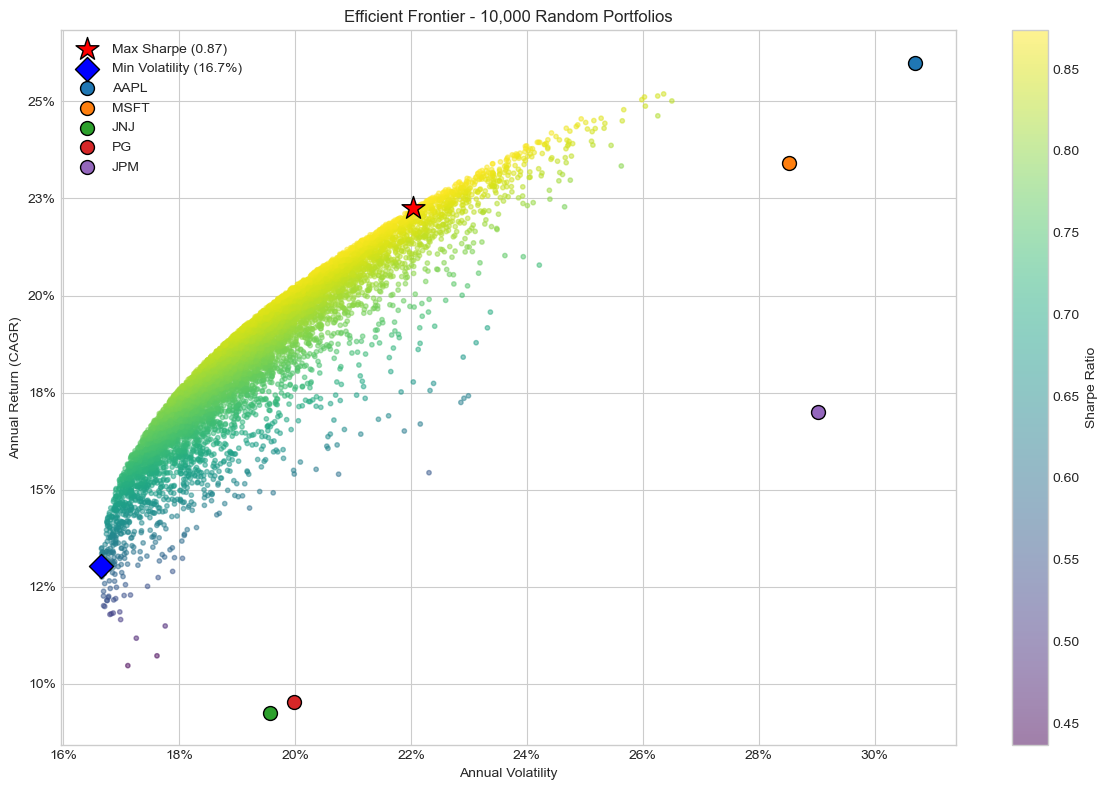

In [12]:
# Efficient Frontier Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter all portfolios
scatter = ax.scatter(
    port_vol_arr, port_returns_arr,
    c=port_sharpe_arr, cmap='viridis',
    alpha=0.5, s=10
)
plt.colorbar(scatter, label='Sharpe Ratio')

# Mark max Sharpe
ax.scatter(max_sharpe_vol, max_sharpe_ret, 
           c='red', marker='*', s=300, edgecolors='black', linewidths=1,
           label=f'Max Sharpe ({max_sharpe_ratio:.2f})', zorder=5)

# Mark min volatility
ax.scatter(min_vol_vol, min_vol_ret,
           c='blue', marker='D', s=150, edgecolors='black', linewidths=1,
           label=f'Min Volatility ({min_vol_vol:.1%})', zorder=5)

# Mark individual assets
for i, asset in enumerate(ASSETS):
    ax.scatter(annual_vol[asset], cagr[asset], 
               marker='o', s=100, edgecolors='black', linewidths=1,
               label=asset, zorder=4)

ax.set_xlabel('Annual Volatility')
ax.set_ylabel('Annual Return (CAGR)')
ax.set_title('Efficient Frontier - 10,000 Random Portfolios')

# Format axes as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

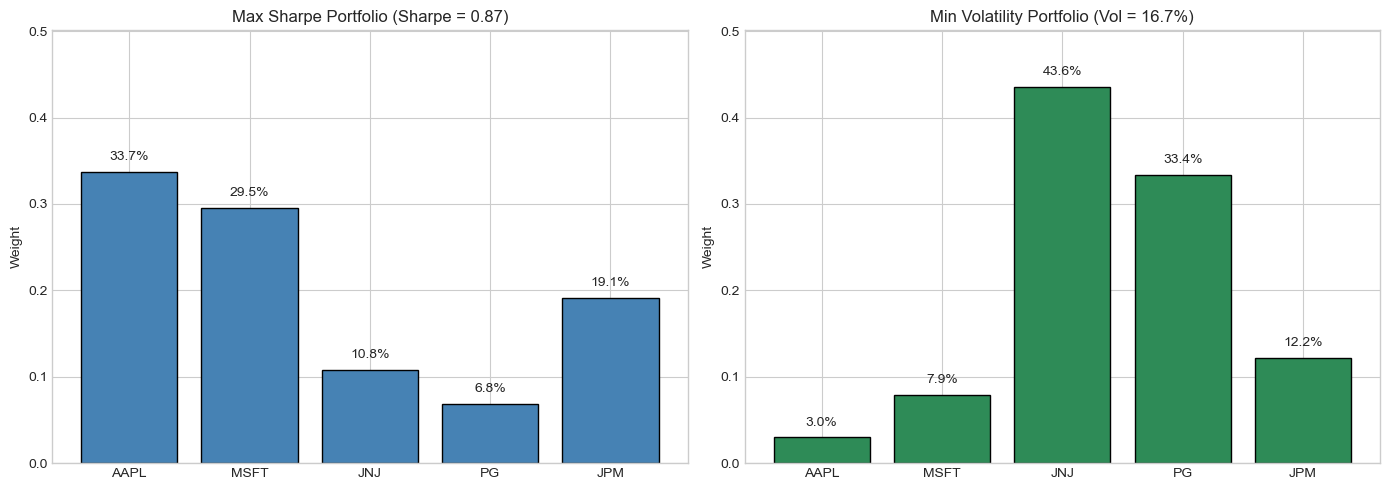

In [13]:
# Portfolio Weights Bar Charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Max Sharpe weights
ax1 = axes[0]
bars1 = ax1.bar(ASSETS, max_sharpe_weights, color='steelblue', edgecolor='black')
ax1.set_ylabel('Weight')
ax1.set_title(f'Max Sharpe Portfolio (Sharpe = {max_sharpe_ratio:.2f})')
ax1.set_ylim(0, max(max_sharpe_weights.max(), min_vol_weights.max()) * 1.15)
for bar, w in zip(bars1, max_sharpe_weights):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{w:.1%}', ha='center', va='bottom', fontsize=10)

# Min Volatility weights
ax2 = axes[1]
bars2 = ax2.bar(ASSETS, min_vol_weights, color='seagreen', edgecolor='black')
ax2.set_ylabel('Weight')
ax2.set_title(f'Min Volatility Portfolio (Vol = {min_vol_vol:.1%})')
ax2.set_ylim(0, max(max_sharpe_weights.max(), min_vol_weights.max()) * 1.15)
for bar, w in zip(bars2, min_vol_weights):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{w:.1%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 4. Backtesting & Comparison

In [15]:
def compute_metrics(daily_returns):
    """
    Compute performance metrics from daily returns series.
    
    Args:
        daily_returns: Series or array of daily returns
    
    Returns:
        dict with: total_return, cagr, volatility, sharpe, max_drawdown
    """
    daily_returns = pd.Series(daily_returns)
    
    # Total return
    cumulative = (1 + daily_returns).prod()
    total_return = cumulative - 1
    
    # CAGR
    n_years = len(daily_returns) / TRADING_DAYS
    cagr = cumulative ** (1 / n_years) - 1
    
    # Volatility
    volatility = daily_returns.std() * np.sqrt(TRADING_DAYS)
    
    # Sharpe
    sharpe = (cagr - RF) / volatility
    
    # Max drawdown
    cum_returns = (1 + daily_returns).cumprod()
    rolling_max = cum_returns.expanding().max()
    drawdown = (cum_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    return {
        'total_return': total_return,
        'cagr': cagr,
        'volatility': volatility,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown
    }

In [16]:
# Define portfolio weights
equal_weights = np.ones(n_assets) / n_assets

# Calculate daily returns for each strategy
strategies = {
    'Equal Weight': returns.dot(equal_weights),
    'Max Sharpe': returns.dot(max_sharpe_weights),
    'Min Volatility': returns.dot(min_vol_weights),
    'SPY (Benchmark)': benchmark_returns[BENCHMARK]
}

# Compute metrics for each strategy
metrics_list = []
for name, rets in strategies.items():
    m = compute_metrics(rets)
    m['Strategy'] = name
    metrics_list.append(m)

metrics_df = pd.DataFrame(metrics_list).set_index('Strategy')
metrics_df = metrics_df[['total_return', 'cagr', 'volatility', 'sharpe', 'max_drawdown']]

# Display formatted
print("BACKTEST PERFORMANCE METRICS")
print("=" * 70)
display_metrics = metrics_df.copy()
display_metrics['total_return'] = display_metrics['total_return'].apply(lambda x: f"{x:.2%}")
display_metrics['cagr'] = display_metrics['cagr'].apply(lambda x: f"{x:.2%}")
display_metrics['volatility'] = display_metrics['volatility'].apply(lambda x: f"{x:.2%}")
display_metrics['sharpe'] = display_metrics['sharpe'].apply(lambda x: f"{x:.2f}")
display_metrics['max_drawdown'] = display_metrics['max_drawdown'].apply(lambda x: f"{x:.2%}")
display_metrics.columns = ['Total Return', 'CAGR', 'Volatility', 'Sharpe', 'Max Drawdown']
print(display_metrics.to_string())

BACKTEST PERFORMANCE METRICS
                Total Return    CAGR Volatility Sharpe Max Drawdown
Strategy                                                           
Equal Weight         298.82%  18.74%     18.81%   0.84      -29.81%
Max Sharpe           404.56%  22.25%     22.04%   0.87      -30.86%
Min Volatility       168.35%  13.04%     16.65%   0.60      -27.59%
SPY (Benchmark)      191.71%  14.21%     19.39%   0.58      -33.72%


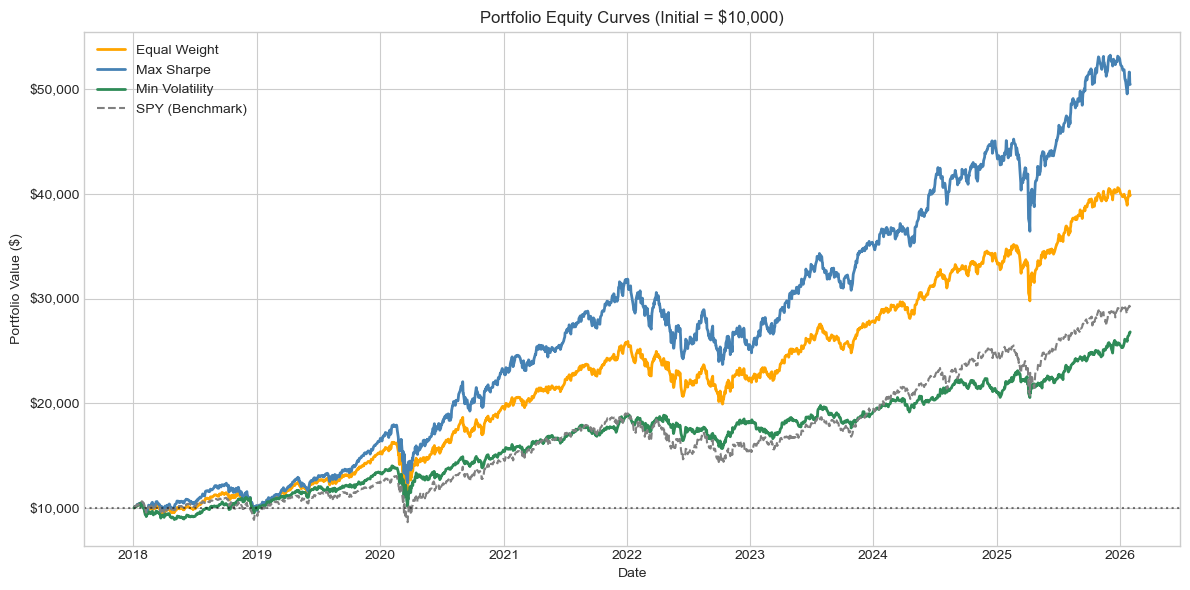


Final Portfolio Values:
  Equal Weight: $39,882
  Max Sharpe: $50,456
  Min Volatility: $26,835
  SPY (Benchmark): $29,171


In [17]:
# Equity curves (base = 10,000)
INITIAL = 10000

fig, ax = plt.subplots(figsize=(12, 6))

colors = {
    'Equal Weight': 'orange',
    'Max Sharpe': 'steelblue',
    'Min Volatility': 'seagreen',
    'SPY (Benchmark)': 'gray'
}

for name, rets in strategies.items():
    equity = INITIAL * (1 + rets).cumprod()
    ax.plot(equity.index, equity, label=name, color=colors[name], 
            linewidth=2 if name != 'SPY (Benchmark)' else 1.5,
            linestyle='-' if name != 'SPY (Benchmark)' else '--')

ax.axhline(y=INITIAL, color='black', linestyle=':', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value ($)')
ax.set_title(f'Portfolio Equity Curves (Initial = ${INITIAL:,})')
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Final values
print("\nFinal Portfolio Values:")
for name, rets in strategies.items():
    final = INITIAL * (1 + rets).prod()
    print(f"  {name}: ${final:,.0f}")

## 5. Conclusion

### Key Findings

**Optimization Results:**
- The Monte Carlo simulation of 10,000 random portfolios successfully identified the efficient frontier.
- The **Max Sharpe portfolio** (Sharpe = 0.87) allocates heavily toward AAPL (34%) and MSFT (30%), reflecting their superior risk-adjusted returns over the sample period.
- The **Min Volatility portfolio** (Vol = 16.65%) favors defensive stocks JNJ (44%) and PG (33%), achieving volatility below any individual asset through diversification.

**Backtest Performance (2018-2026):**
- Max Sharpe delivered the highest total return (405%) and CAGR (22.25%), turning $10,000 into $50,456.
- Min Volatility provided the lowest drawdown (-27.6%) at the cost of lower returns (168% total).
- Equal Weight achieved a strong Sharpe ratio (0.84) with moderate risk, outperforming SPY.
- All optimized portfolios outperformed the SPY benchmark on a risk-adjusted basis.

**Observations:**
- The period 2018-2026 favored growth/tech stocks, which explains the Max Sharpe portfolio's tilt.
- Diversification reduced portfolio volatility below individual asset levels, demonstrating the core benefit of Markowitz optimization.
- The Max Sharpe portfolio accepted higher volatility (22%) and drawdown (-31%) in exchange for superior returns.

**Limitations:**
- Weights are derived from historical data; future performance may differ.
- Monte Carlo sampling approximates the true efficient frontier but may not find the global optimum.
- Transaction costs and rebalancing are not modeled.